In [1]:
import lightgbm as lgb
import numpy as np
import pickle
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def save_pkl(file_dir, data):
    f = open(file_dir,"wb")
    pickle.dump(data, f, protocol=4)
    f.close()
    
def read_pkl(file_dir):
    f = open(file_dir,"rb")
    data = pickle.load(f)
    return data

def get_score(valid_y_exp, pred):
    return mean_absolute_error(pred, valid_y_exp)


Reading CSV file

In [3]:
df = pd.read_csv("Dataset/AAl_T_Weather_SkewFix_19des-22mar.csv")


Extracting our Timestamp column to week, year, month, day and hour columns, as Lightgbm can't handle Timestamp only numbers

In [4]:
df = df.rename(columns={"Recorded":"time","heat_index":"temperature","rh":"humidity","wdir":"wind_direction","wspd":"wind_speed",
                        'NO2': 'NO2_Concentration','NOx': 'NOx_Concentration',"O3":"O3_Concentration"})
df['time'] = pd.to_datetime(df['time'])
df.index = df['time']
df['time_week'] = df.index.map(lambda x: x.weekday)
df['time_year'] = df.index.map(lambda x: x.year)
df['time_month'] = df.index.map(lambda x: x.month)
df['time_day'] = df.index.map(lambda x: x.day)
df['time_hour'] = df.index.map(lambda x: x.hour)


In [5]:
df

,time,NO2_Concentration,NOx_Concentration,O3_Concentration,temperature,humidity,pressure,wind_direction,wdir_cardinal,wind_speed,time_week,time_year,time_month,time_day,time_hour
time,,,,,,,,,,,,,,,
2019-12-06 10:00:00,2019-12-06 10:00:00,6.43,8.06,69.81,9.0,87.0,992.65,260.0,W,31.0,4,2019,12,6,10
2019-12-06 10:30:00,2019-12-06 10:30:00,9.36,11.62,64.26,9.0,87.0,993.65,260.0,W,33.0,4,2019,12,6,10
2019-12-06 11:00:00,2019-12-06 11:00:00,10.42,13.22,62.80,8.0,93.0,993.65,250.0,WSW,33.0,4,2019,12,6,11
2019-12-06 11:30:00,2019-12-06 11:30:00,9.28,12.08,64.50,8.0,93.0,993.65,250.0,WSW,30.0,4,2019,12,6,11
2019-12-06 12:00:00,2019-12-06 12:00:00,13.09,17.45,57.96,8.0,93.0,993.65,250.0,WSW,24.0,4,2019,12,6,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-07 10:30:00,2022-03-07 10:30:00,6.96,9.64,69.91,-1.0,100.0,1026.63,230.0,SW,7.0,0,2022,3,7,10
2022-03-07 11:00:00,2022-03-07 11:00:00,8.89,12.76,67.22,2.0,93.0,1026.63,230.0,SW,13.0,0,2022,3,7,11
2022-03-07 11:30:00,2022-03-07 11:30:00,7.90,11.25,69.61,2.0,100.0,1026.63,240.0,WSW,17.0,0,2022,3,7,11


Choosing Between Base or with weather data

In [6]:
Airs = df[["NOx_Concentration","NO2_Concentration","O3_Concentration",'time_year', 'time_month', 'time_week', 'time_day', 
           'time_hour',"temperature", "pressure", "humidity", "wind_direction", "wind_speed",]].copy()
#Airs = df[["NO2_Concentration", "NOx_Concentration","O3_Concentration"
# 'time_year', 'time_month', 'time_week', 'time_day', 
          # 'time_hour',
#          ]].copy()

season_dict={'April':"summer",
             'May':"summer",
             'June':"monsoon",
             'July':"monsoon",
             "August":"monsoon",
             'September':"pre-winter",
             'October':"pre-winter",
             'November':"winter",
             'December':"winter",
             'January':"winter",
             'February':"winter"}

def datetime_features(df):
  df['weekday']=df.timestamp.dt.day_name()
  df['month']=df.timestamp.dt.month_name()
  df['date']=df.timestamp.dt.strftime("%Y-%m-%d")
  df['time']=df.timestamp.dt.strftime("%H%M").astype("int")
  df["workinghrs"]=df["time"].apply(lambda x: 1 if x>600 & x<1800 else 0)
  df["season"]=df["month"].map(season_dict)

In [7]:
listing = []
for i in range(Airs.shape[0]-7105):
    tmp = Airs.iloc[i]
    tmp = np.hstack((tmp))
    listing.append(tmp)
        
    

In [8]:
NOx_list = Airs['NOx_Concentration'].values
NO2_list = Airs['NO2_Concentration'].values
O3_list = Airs['O3_Concentration'].values
Y_NOx_list = []
Y_NO2_list = []
Y_O3_list = []

X_extend_list = []
for i in range(1,Airs.shape[0]-7104):
    Y_NOx_list.append(NOx_list[i])
    Y_NO2_list.append(NO2_list[i])
    Y_O3_list.append(O3_list[i])

In [9]:
test_x = []
for i in range(Airs.shape[0]-7105,Airs.shape[0]-26):
    tmp = Airs.iloc[i]
    tmp = np.hstack((tmp))
    test_x.append(tmp)

In [10]:
Y_NOx_Test_list = []
Y_NO2_Test_list = []
Y_O3_Test_list = []
for i in range(Airs.shape[0]-7104,Airs.shape[0]-25):
    Y_NOx_Test_list.append(NOx_list[i])
    Y_NO2_Test_list.append(NO2_list[i])
    Y_O3_Test_list.append(O3_list[i])

In [11]:
Y_Test_NOx = np.vstack(Y_NOx_Test_list)
Y_Test_NO2 = np.vstack(Y_NO2_Test_list)
Y_Test_O3 = np.vstack(Y_O3_Test_list)
Y_Test_NOx = Y_Test_NOx.flatten()
Y_Test_NO2 = Y_Test_NO2.flatten()
Y_Test_O3 = Y_Test_O3.flatten()
X_Test = np.vstack(test_x)

In [12]:
Y_NOx = np.vstack(Y_NOx_list)
Y_NO2 = np.vstack(Y_NO2_list)
Y_O3 = np.vstack(Y_O3_list)
Y_NOx = Y_NOx.flatten()
Y_NO2 = Y_NO2.flatten()
Y_O3 = Y_O3.flatten()
X = np.vstack(listing)

In [13]:
print(X.shape,Y_NOx.shape,Y_NO2.shape)

(32357, 13) (32357,) (32357,)


In [14]:
#listfeature_name = ['NOx_Concentration','NO2_Concentration',"time_year", 'time_month','time_week','time_day','time_hour',]

In [15]:
#listfeature_name = ['NOx_Concentration','NO2_Concentration',"O3_Concentration"]

In [16]:
listfeature_name = ['NOx_Concentration','NO2_Concentration',"O3_Concentration","time_year", 'time_month',          # feature 0-1# feature 2-6
                    'time_week','time_day','time_hour',
                    'temperature','pressure','humidity', 'wind_direction', 'wind_speed',#"NO2ratio","NOxratio"#"O3_Concentration",
                    ]

In [17]:
def train_test(model_param, train_X, test_X, train_Y, test_Y, save_dir):
    time_start = time.time()
    lgb_train = lgb.Dataset(train_X, train_Y)
    lgb_eval = lgb.Dataset(test_X, test_Y, reference=lgb_train)
    params = {
    'task': 'train',
    'verbosity': -1,
    'gpu_use_dp': True,
    'device_type': 'gpu',
    'boosting_type': 'gbdt',
    'objective': 'regression_l1',
    'metric': {'mae'},
    'max_depth': model_param['depth'], #impact on model performance and train time
    'num_leaves': model_param['leaf'],
    'min_data_in_leaf': 20,
    'learning_rate': model_param['lr'],
    'num_threads':7
    # 'feature_fraction': 1, #can be used to speed up training and deal with overfitting
    # 'bagging_fraction': 0.8,
    # 'bagging_freq': 1,
    # 'bagging_seed': 3,
#     'min_sum_hessian_in_leaf': 100,
    }
    evaluation_results  = {}

    gbm = lgb.train(params,
                    train_set = lgb_train,
                    num_boost_round=model_param['tree'],
                    valid_sets=[lgb_train, lgb_eval],
                    valid_names=['Train', 'Valid'],
                    #categorical_feature=2,
                    #evals_result= evaluation_results,
                    #verbose_eval=500,
                    #early_stopping_rounds=3,
                    feature_name = listfeature_name,
                    callbacks=[lgb.early_stopping(stopping_rounds=3),lgb.log_evaluation(period=500),lgb.record_evaluation(eval_result=evaluation_results)]) 

    test_predict = gbm.predict(test_X)
    score = get_score(test_predict, test_Y)
    save_pkl(save_dir, gbm)
    print('running time: ', time.time() - time_start)

    lgb.plot_metric(evaluation_results)
    return score

In [18]:
train_X_NOx, test_X_NOx, train_Y_NOx, test_Y_NOx = train_test_split(X, Y_NOx, test_size=0.2,random_state=42)
print(train_X_NOx.shape, test_X_NOx.shape, train_Y_NOx.shape, test_Y_NOx.shape)

(25885, 13) (6472, 13) (25885,) (6472,)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[179]	Train's l1: 1.39762	Valid's l1: 1.44429
running time:  1.1189312934875488


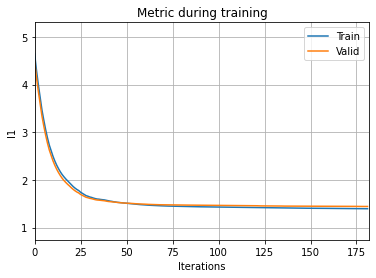

In [19]:
model_param={'lr': 0.1, 'depth': -1, 'tree': 3000, 'leaf': 10}
score = train_test(model_param, train_X_NOx, test_X_NOx, train_Y_NOx, test_Y_NOx, "LightGBM/lightgbm_T_W_NOx_10_1.model")

In [20]:
train_X_NO2, test_X_NO2, train_Y_NO2, test_Y_NO2 = train_test_split(X, Y_NO2, test_size=0.2,random_state=42)
print(train_X_NO2.shape, test_X_NO2.shape, train_Y_NO2.shape, test_Y_NO2.shape)

(25885, 13) (6472, 13) (25885,) (6472,)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[202]	Train's l1: 1.05614	Valid's l1: 1.10739
running time:  0.51999831199646


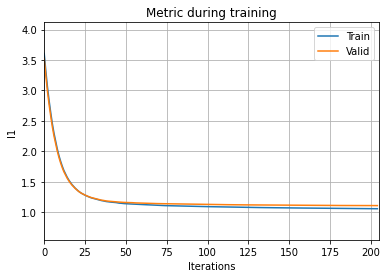

In [21]:
model_param={'lr': 0.1, 'depth': -1, 'tree': 3000, 'leaf': 10}
score = train_test(model_param, train_X_NO2, test_X_NO2, train_Y_NO2, test_Y_NO2, "LightGBM/lightgbm_T_W_NO2_10_1.model")

In [22]:
train_X_O3, test_X_O3, train_Y_O3, test_Y_O3 = train_test_split(X, Y_O3, test_size=0.2,random_state=42)
print(train_X_O3.shape, test_X_O3.shape, train_Y_O3.shape, test_Y_O3.shape)

(25885, 13) (6472, 13) (25885,) (6472,)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[387]	Train's l1: 2.15287	Valid's l1: 2.24217
running time:  0.9095592498779297


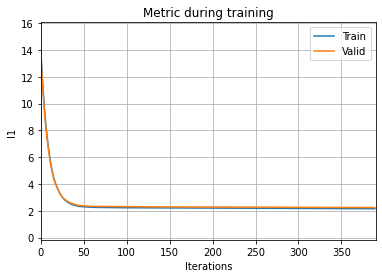

In [23]:
model_param={'lr': 0.1, 'depth': -1, 'tree': 3000, 'leaf': 10}
score = train_test(model_param, train_X_O3, test_X_O3, train_Y_O3, test_Y_O3, "LightGBM/lightgbm_T_W_O3_10_1.model")

In [24]:
gbmNO2 = read_pkl("LightGBM/lightgbm_T_W_NO2_10_1.model")
predict_NO2 = gbmNO2.predict(X_Test)
score_NO2 = get_score(predict_NO2, Y_Test_NO2)
score_NO2

1.148509197913284

In [25]:
gbmNOx = read_pkl("LightGBM/lightgbm_T_W_NOx_10_1.model")
predict_NOx = gbmNOx.predict(X_Test)
score_NOx = get_score(predict_NOx, Y_Test_NOx)
score_NOx

1.501447333562073

In [26]:
gbmO3 = read_pkl("LightGBM/lightgbm_T_W_O3_10_1.model")
predict_O3 = gbmO3.predict(X_Test)
score_O3 = get_score(predict_O3, Y_Test_O3)
score_O3

2.1900254594004296

In [27]:
predictionsDf = pd.DataFrame({"Pred_NO2":predict_NO2,"Pred_NOx":predict_NOx,"Pred_O3":predict_O3})
predictionsDf = predictionsDf.round(2)
predictionsDf.to_csv("LightGBM/AAl_T_Prediction.csv",index=False)

In [28]:
realDF = pd.DataFrame({"Real_NO2":Y_Test_NO2,"Real_NOx":Y_Test_NOx,"Real_O3":Y_Test_O3})
realDF.to_csv("LightGBM/AAl_T_Real.csv",index=False)

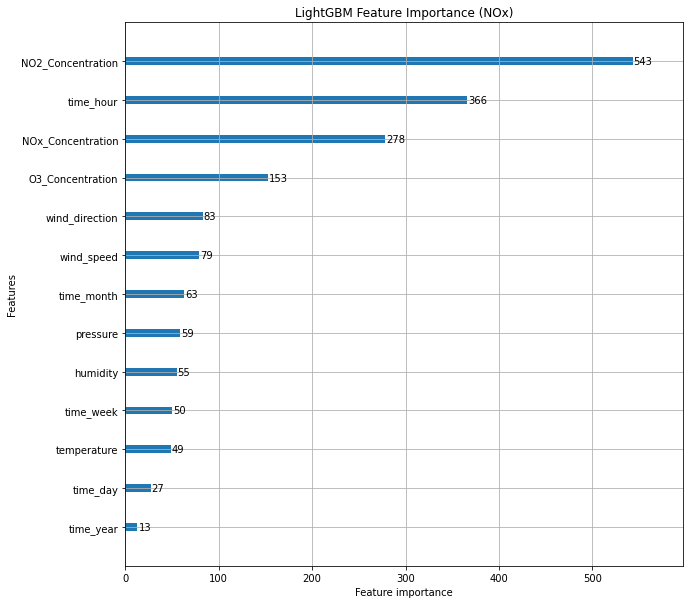

In [29]:
ax = lgb.plot_importance(gbmNO2,figsize=(10,10),importance_type="auto")
plt.title("LightGBM Feature Importance (NOx)")
plt.show()

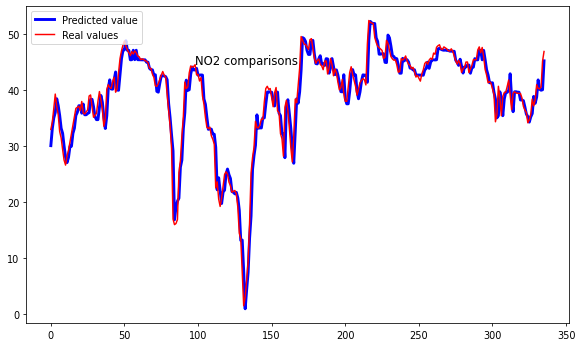

In [31]:
plt.figure(num=None,dpi=70, figsize=(10, 6),facecolor='w', edgecolor='k')
plt.plot(predict_O3[:336], "-b",linewidth=3,  label='Predicted value')
plt.plot(Y_Test_O3[:336], "-r", label='Real values', )
plt.legend(loc="upper left")
plt.title('NO2 comparisons', x=0.5, y=0.8, loc='right')
plt.show()